# Artificial Neural Networks and Deep Learning

---

## Homework 1

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Boracchi
# directory of my folder in google drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Boracchi


## ⚙️ Import Libraries

In [ ]:
# libraries settings: here I'll add all the necessary libraries during
# the code development

seed = 85 # random variable to make the code reproducible

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import numpy as np
import hashlib
import logging
import random

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [ ]:
data = np.load('training_set.npz') # load the blood cells dataset into a variable called 'data'
print(data.files)
# as we can see in the previus output, the dataset is composed by two arrays: images and labels

['images', 'labels']


In [ ]:
# Define a mapping of labels to their corresponding digit names
classes = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'} # 8 classes
# Save unique labels
unique_labels = list(classes.values())

In [ ]:
# splitting between images and labels
X = data['images']
y = data['labels']
print(X.shape)
print(y.shape)
# we have 13759 observations that are images of height and weight equal to 96 and 3 channels (RGB images)

(13759, 96, 96, 3)
(13759, 1)


In [ ]:
# show a sample of images from the training set

num_img = 50 # 50 random images
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(10, 5, figsize=(20, 20))

# iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{classes[y[idx][0]]}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## Searching for duplicates

In [ ]:
# Dictionary to store image hashes and their indices
hash_dict = {}
duplicates = []

for idx, img in enumerate(X):
    # Convert the image to bytes to create a hash
    img_bytes = img.tobytes()
    img_hash = hashlib.md5(img_bytes).hexdigest()

    # Check if the hash exists in hash_dict
    if img_hash in hash_dict:
        # print(f"Duplicate found at index {idx}, duplicate of index {hash_dict[img_hash]}")
        duplicates.append(idx)  # Mark this index as a duplicate
    else:
        hash_dict[img_hash] = idx  # Store unique hash with its index

# Remove duplicates from X and y
X_unique = np.delete(X, duplicates, axis=0)
y_unique = np.delete(y, duplicates, axis=0)

# Save the deduplicated dataset if desired
np.savez('deduplicated_training_set.npz', images=X_unique, labels=y_unique)

print(f"Removed {len(duplicates)} duplicates. New dataset has {len(X_unique)} images.")

Removed 1806 duplicates. New dataset has 11953 images.


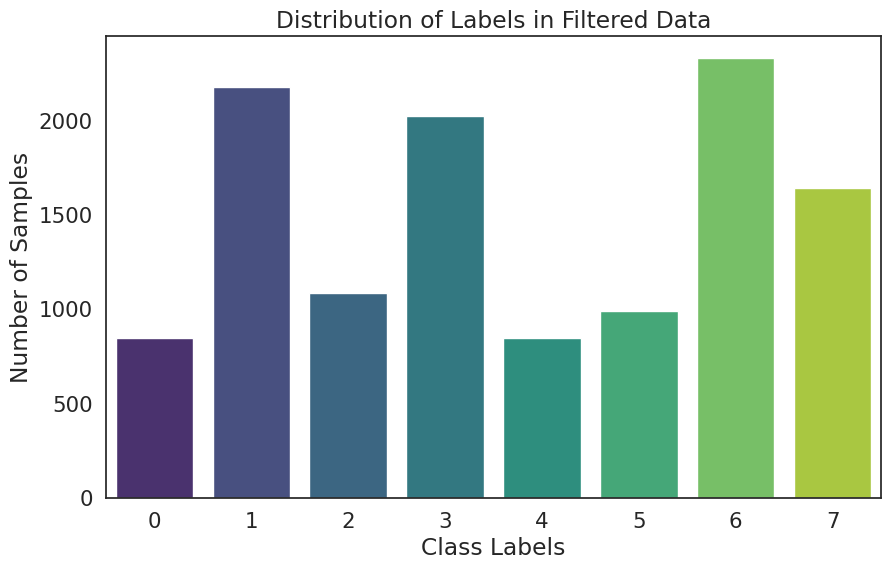

In [ ]:
# Count the number of occurrences for each label in y
unique_labels, label_counts = np.unique(y_unique, return_counts=True)

# Plotting the label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_labels, y=label_counts, palette='viridis')

plt.title('Distribution of Labels in Filtered Data')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(unique_labels)
plt.show()

# DOWNSAMPLING and DATA AUGMENTATION

In [ ]:
class_dimension = 850 # number of obs I want for each class

# to memorize the subsampling
subsample_images = []
subsample_labels = []

# loop for the 8 classes
for label in np.unique(y_unique):

    # Obtaining image indexes belonging to the class
    indices = np.where( y_unique == label)[0]

    # If the class is bigger than class_dimension it randomly downsample the class
    if len(indices) > class_dimension:
        selected_indices = np.random.choice(indices, class_dimension, replace=False)
    else:
        selected_indices = indices  # Se sono <= 1049, usa tutti gli indici

    # Aggiungi le immagini e le etichette selezionate al sottoinsieme
    subsample_images.extend(X_unique[selected_indices])
    subsample_labels.extend(y_unique[selected_indices])

# Converti in array finali per il sottoinsieme
X_down = np.array(subsample_images)
y_down = np.array(subsample_labels)

print('Downsampling done. New dimension: ', len(subsample_images))
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_down, columns=['digit'])['digit'].value_counts())

Downsampling done. New dimension:  6799
Counting occurrences of target classes:
digit
0    850
1    850
2    850
3    850
5    850
6    850
7    850
4    849
Name: count, dtype: int64


In [ ]:
# Normalization

X_down = X_down / 255

Immagine originale:
Original - Min: 0.023529411764705882, Max: 1.0, Mean: 0.6520246119281046


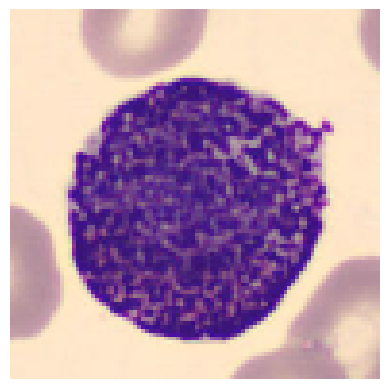

Immagine augmentata:
Augmented - Min: 0.0235294122248888, Max: 1.0, Mean: 0.6520245671272278


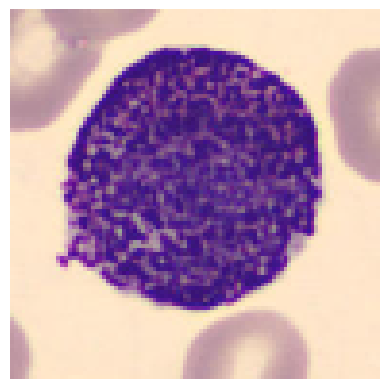

In [ ]:
# Funzione per visualizzare il range di valori dell'immagine
def print_image_stats(img, name="Image"):
    print(f"{name} - Min: {np.min(img)}, Max: {np.max(img)}, Mean: {np.mean(img)}")

# Funzione per visualizzare una singola immagine
def show_image(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

y_one = np.squeeze(y_down)

# Seleziona un'immagine di esempio dalla classe 0
class_images = X_down[y_one == 0]  # Classe 0, per esempio
original_img = class_images[np.random.randint(0, len(class_images))]

# Mostra l'immagine originale e stampa le statistiche
print("Immagine originale:")
print_image_stats(original_img, name="Original")
show_image(original_img)

# Configura un'augmentation semplice per il test (Flip)
augmentation_flip = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical")  # Flip orizzontale e verticale
])

# Applica l'augmentation
augmented_img = augmentation_flip(tf.expand_dims(original_img, axis=0), training=True)

# Rimuovi la dimensione batch
augmented_img = tf.squeeze(augmented_img, axis=0).numpy()

# Mostra l'immagine augmentata e stampa le statistiche
print("Immagine augmentata:")
print_image_stats(augmented_img, name="Augmented")
show_image(augmented_img)


### Data Augmentation

In [ ]:
# LOW
augmentation_low = tf.keras.Sequential([
    tfkl.RandomZoom(0.2),  # Zoom leggero, circa 20%
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.2, 0.2),  # Traslazione 20%
    tfkl.RandomRotation(0.2),  # Rotazione fino a ±20°
    tfkl.RandomBrightness(0.2, value_range=(0, 1)),  # Luminosità con range limitato 0.8-1.2 per simulare diversi tipi di luminosità dei microscopi
    tfkl.RandomContrast(0.2),  # Contrasto, range 0.8-1.2 sempre per lo strumento ovvero il microscopio
], name='preprocessing')

In [ ]:
# MEDIUM
augmentation_med = tf.keras.Sequential([
    tfkl.RandomZoom(0.4),  # Zoom leggero, circa 20%
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.4, 0.4),  # Traslazione 20%
    tfkl.RandomRotation(0.4),  # Rotazione fino a ±20°
    tfkl.RandomBrightness(0.4, value_range=(0, 1)),  # Luminosità con range limitato 0.8-1.2 per simulare diversi tipi di luminosità dei microscopi
    tfkl.RandomContrast(0.4),  # Contrasto, range 0.8-1.2 sempre per lo strumento ovvero il microscopio
], name='preprocessing')

In [ ]:
# HIGH
augmentation_high = tf.keras.Sequential([
    tfkl.RandomZoom(0.6),  # Zoom leggero, circa 20%
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.4, 0.4),  # Traslazione 20%
    tfkl.RandomRotation(0.4),  # Rotazione fino a ±20°
    tfkl.RandomBrightness(0.6, value_range=(0, 1)),  # Luminosità con range limitato 0.8-1.2 per simulare diversi tipi di luminosità dei microscopi
    tfkl.RandomContrast(0.6),  # Contrasto, range 0.8-1.2 sempre per lo strumento ovvero il microscopio
], name='preprocessing')

In [ ]:
# VERY HIGH
augmentation_vhigh = tf.keras.Sequential([
    tfkl.RandomZoom(0.6),  # Zoom leggero, circa 20%
    tfkl.RandomFlip('horizontal_and_vertical'),
    tfkl.RandomTranslation(0.4, 0.4),  # Traslazione 20%
    tfkl.RandomRotation(0.4),  # Rotazione fino a ±20°
    tfkl.RandomBrightness(0.8, value_range=(0, 1)),  # Luminosità con range limitato 0.8-1.2 per simulare diversi tipi di luminosità dei microscopi
    tfkl.RandomContrast(0.8),  # Contrasto, range 0.8-1.2 sempre per lo strumento ovvero il microscopio
], name='preprocessing')

In [ ]:
# ONLY ZOOM
augmentation_zoom_l = tf.keras.Sequential([tfkl.RandomZoom(0.2)])
augmentation_zoom_m = tf.keras.Sequential([tfkl.RandomZoom(0.4)])
augmentation_zoom_h = tf.keras.Sequential([tfkl.RandomZoom(0.6)])

In [ ]:
# ONLY TRANSLATION
augmentation_tra_l = tf.keras.Sequential([tfkl.RandomTranslation(0.2,0.2)])
augmentation_tra_m = tf.keras.Sequential([tfkl.RandomTranslation(0.4,0.4)])
augmentation_tra_h = tf.keras.Sequential([tfkl.RandomTranslation(0.6,0.6)])

In [ ]:
# ONLY ROTATION
augmentation_rot_l = tf.keras.Sequential([tfkl.RandomRotation(0.2)])
augmentation_rot_m = tf.keras.Sequential([tfkl.RandomRotation(0.4)])
augmentation_rot_h = tf.keras.Sequential([tfkl.RandomRotation(0.6)])

In [ ]:
# ONLY BRIGHTNESS
augmentation_bri_l = tf.keras.Sequential([tfkl.RandomBrightness(0.2, value_range=(0, 1))])
augmentation_bri_m = tf.keras.Sequential([tfkl.RandomBrightness(0.4, value_range=(0, 1))])
augmentation_bri_h = tf.keras.Sequential([tfkl.RandomBrightness(0.6, value_range=(0, 1))])

In [ ]:
# Lista di 14 augmentations diverse
augmentations = [
    augmentation_vhigh,
    augmentation_high,
    augmentation_med,
    augmentation_low,
    augmentation_zoom_l,
    augmentation_zoom_m,
    augmentation_zoom_h,
    augmentation_tra_l,
    augmentation_tra_m,
    augmentation_tra_h,
    augmentation_rot_l,
    augmentation_rot_m,
    augmentation_rot_h,
    augmentation_bri_l,
    augmentation_bri_m,
    augmentation_bri_h
]

# Parametri
N = 400  # Numero di immagini casuali da selezionare per ogni classe

# Recuperiamo le classi uniche nel dataset
classi_uniche = np.unique(y_down)

# Liste per immagazzinare i nuovi campioni
nuove_immagini = []
nuovi_labels = []

# Selezione casuale di N immagini per ogni classe
for classe in classi_uniche:
    # Troviamo gli indici delle immagini appartenenti a questa classe
    indici_classe = np.where(y_one == classe)[0]

    # Selezioniamo N indici casuali per questa classe
    indici_random = np.random.choice(indici_classe, N, replace=False)

    # Per ogni immagine selezionata, applicheremo un'augmentation casuale
    for indice in indici_random:
        immagine = X_down[indice]  # Estrai l'immagine

        # Seleziona casualmente una delle augmentations
        augmentation = np.random.choice(augmentations)  # Seleziona una trasformazione casuale

        # Applica l'augmentation all'immagine
        immagine_aug = augmentation(np.expand_dims(immagine, axis=0))  # Aggiungiamo batch dimension

        # Salviamo l'immagine e il suo label
        nuove_immagini.append(immagine_aug[0])  # Rimuoviamo la batch dimension
        nuovi_labels.append(classe)

# Convertiamo le liste in array numpy per facilitare l'elaborazione successiva
nuove_immagini = np.array(nuove_immagini)
nuovi_labels = np.array(nuovi_labels)

# Aggiungiamo i nuovi campioni al dataset originale
X_down_augmented = np.concatenate([X_down, nuove_immagini], axis=0)
y_down_augmented = np.concatenate([y_one, nuovi_labels], axis=0)

In [ ]:
# Numero di campioni da visualizzare
num_samples = 40

# Seleziona 40 indici casuali da X_down
indici_random = np.random.choice(len(X_down_augmented), num_samples, replace=False)

# Seleziona le immagini corrispondenti agli indici casuali
campioni_random = X_down_augmented[indici_random]

# Creiamo una griglia di subplots per visualizzare le immagini
fig, axes = plt.subplots(8, 5, figsize=(15, 20))  # 8 righe, 5 colonne
axes = axes.flatten()  # Rende più facile iterare sugli assi

# Mostriamo le immagini
for i, ax in enumerate(axes):
    if i < len(campioni_random):
        ax.imshow(campioni_random[i])
        ax.axis('off')  # Disabilita gli assi
        ax.set_title(f"Campione {i+1}")  # Titolo per ogni immagine
    else:
        ax.axis('off')  # Se ci sono meno di 40 immagini, nasconde gli assi inutilizzati

# Mostra la griglia di immagini
plt.tight_layout()
plt.show()

## Split train and test set

In [ ]:
# keeping 80% for the training set and 20% for the validation
X_train, X_val, y_train, y_val = train_test_split(X_down_augmented, y_down_augmented, test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)

Train: (7999, 96, 96, 3) (7999,)
Validation: (2000, 96, 96, 3) (2000,)


## Bilanciamento delle classi

In [ ]:
# Flatten y_train to a 1D array before passing it to compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(class_weight_dict)

{0: 1.0048994974874372, 1: 1.0089556004036326, 2: 1.0008758758758758, 3: 1.0192405708460754, 4: 0.9919394841269841, 5: 1.0089556004036326, 6: 0.9735881207400194, 7: 0.9929245283018868}


In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

In [ ]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])
print('"Default" label:', np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
"Default" label: 6


## Network Parameters

In [ ]:
input_shape = (96,96,3) # input shape basta che sia multiplo di 32 per la SENet quindi lasciamo 96,96,3
output_shape = y_train.shape[1] # output shape of the model: 8 classi
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

# it makes sense because the input shape is the dimension of the image and 3 channels
# and the output is 8 as the number of the possible classes

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
epochs = 300 # epochs
batch_size = 64 # batch
learning_rate = 0.001 # step size for updating the model's weights

# Initialise configuration for convolutional layers
stack = 1 # solo un layer
filters = 32 # convolutional layers
kernel_size = 3

In [ ]:
# early stopping
patience = 200

early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'max',
    patience = patience,
    restore_best_weights = True
)

callbacks = [early_stopping]

## 🛠️ Train and Save the Model

In [ ]:
# RETE PARTENDO DA ZERO
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Conv2D, MaxPooling2D, Dropout

# Crea il modello sequenziale
model = Sequential()

# Aggiungi il layer di normalizzazione (rescaling) delle immagini
model.add(layers.Rescaling(1./255, input_shape=(96, 96, 3), name='rescaling'))

# Primo strato convoluzionale
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# Secondo strato convoluzionale
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# Terzo strato convoluzionale
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

# Terzo strato convoluzionale
#model.add(Conv2D(256, (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

# Quarto strato convoluzionale
#model.add(Conv2D(512, (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

# Quinto strato convoluzionale
#model.add(Conv2D(512, (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

# Sesto strato convoluzionale (opzionale, per una rete ancora più profonda)
#model.add(Conv2D(1024, (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Strato denso finale per la classificazione (output)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))  # 8 classi di output

# Compilazione del modello
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display Model Summary and Plot
model.summary(expand_nested=True, show_trainable=True)
#tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ rescaling (Rescaling)               │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d (Conv2D)                     │ (None, 94, 94, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization                 │ (None, 94, 94, 32)           │           128 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d (MaxPooling2D)        │ (None, 47, 47, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 47, 47, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_1 (Conv2D)                   │ (None, 45, 45, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_1               │ (None, 45, 45, 64)           │           256 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_1 (MaxPooling2D)      │ (None, 22, 22, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_1 (Dropout)                 │ (None, 22, 22, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_2 (Conv2D)                   │ (None, 20, 20, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_2               │ (None, 20, 20, 128)          │           512 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_2 (MaxPooling2D)      │ (None, 10, 10, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_2 (Dropout)                 │ (None, 10, 10, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 128)                  │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 256)                  │        33,024 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_3 (Dropout)                 │ (None, 256)                  │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_1 (Dense)                     │ (None, 8)                    │         2,056 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 129,224 (504.78 KB)

 Trainable params: 128,776 (503.03 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train the model
history = model.fit(
    x=X_train * 255,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    class_weight=class_weight_dict,
    validation_data=(X_val * 255, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)] # restore serve per il best model
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model.save('weights.keras')

# Free memory by deleting the model instance
del model

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training loss', alpha=.8, linewidth=2)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8, linewidth=2)
plt.title('Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, linewidth=2)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, linewidth=2)
plt.title('Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()